In [1]:
 ## Import libraries
import datetime
from fredapi import Fred
import numpy as np
import pandas as pd
from pytrends.request import TrendReq
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
import yfinance as yf

# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [2]:
apple_raw = pd.read_csv('AAPL_quarterly_financials.csv')
apple_raw.index = apple_raw.name
apple = pd.DataFrame(apple_raw.loc["BasicEPS"]).iloc[2:,]

In [3]:
apple.index = pd.to_datetime(apple.index)
#Check if NAs are NO Dividend Period (why are there NA's??)
apple = apple.sort_index().fillna(0,)

#Cut to match length
apple_lim = apple[apple.index >= '2003-09-30']

# 1.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.

In [4]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["Steve Jobs", "Macbook", "Tarriff" , "Labor Shortage" , "Minimum Wage", "Keynote", "Soap", "Banana", "Airplane"]  # Add your keywords here
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [5]:
#Resample to Make it Quarterly 
dfq = df.resample("Q").mean()
dfq

,Steve Jobs,Macbook,Tarriff,Labor Shortage,Minimum Wage,Keynote,Soap,Banana,Airplane
date,,,,,,,,,
2004-03-31,1.000000,0.000000,73.000000,16.333333,39.333333,24.333333,79.333333,37.666667,96.666667
2004-06-30,0.666667,0.000000,74.666667,26.000000,41.000000,19.666667,76.333333,41.333333,90.333333
2004-09-30,1.000000,0.000000,74.333333,15.666667,39.666667,26.000000,74.666667,41.333333,86.333333
2004-12-31,1.000000,0.000000,82.000000,15.666667,38.000000,17.333333,67.666667,46.333333,89.666667
2005-03-31,1.000000,0.000000,77.000000,22.000000,39.333333,33.666667,70.000000,45.333333,88.000000
...,...,...,...,...,...,...,...,...,...
2023-03-31,1.333333,75.000000,23.333333,36.333333,70.333333,17.333333,70.000000,64.000000,52.666667
2023-06-30,1.000000,65.666667,20.333333,29.333333,68.333333,17.333333,70.666667,64.333333,52.333333
2023-09-30,1.333333,73.333333,22.000000,27.666667,62.000000,19.333333,72.666667,65.666667,54.666667


# 2.) Import data. Train, Test, Holdout (80%,15%,5%)

In [6]:
#Test Train Split
X_train, X_temp, y_train, y_temp = train_test_split(dfq, apple_lim, test_size = 0.2, random_state = 50)

#Test-Holdout Split
X_test, X_holdout, y_test, y_holdout = train_test_split(X_temp, y_temp, test_size = 0.25, random_state = 50)

# 3.) Normalize all the X data

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [54]:
lasso = Lasso(alpha = 0.3)
    #no cols appear at lambda = 0.5
lasso.fit(X_scaled, y_train)
coefficients = lasso.coef_
coefficients

array([-0.        ,  0.        , -0.10048237,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.00161799, -0.        ])

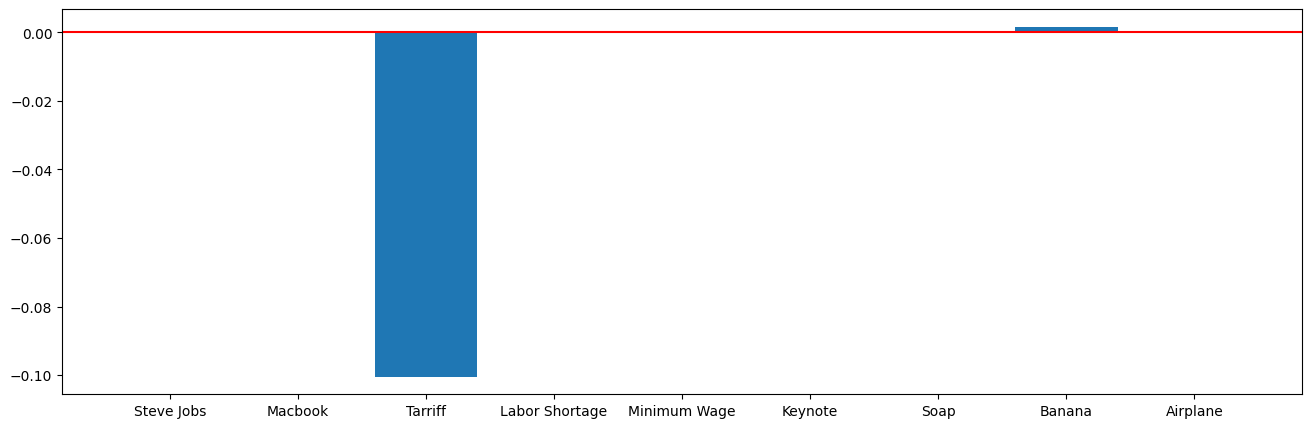

In [55]:
#Plot Bar Chart
plt.figure(figsize= (16, 5))
plt.bar(dfq.columns, coefficients)
plt.axhline(0, color = "r")
plt.show()


# 5.) Do these coefficient magnitudes make sense?

The coefficient magnitude makes sense since we would expect that discussion of tariffs would negatively affect the EPS. It's interesting that the only other remaining coefficient is "banana", which I would not have expected to be correlated in any way with the Apple EPS. I think this could potentially be caused by a mistake where people are getting results for 'apple' the fruit and not 'apple' the company, the former of which would often be searched with bananas, but I'm unsure as to any other reason why we would be seeing this relationship.

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

# 7.) Run a cross validation. What is your ideal lambda?